In [ ]:
# %%

import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchsummary as summary
import librosa.display
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from data.config import *
from data.dataset import MixtureDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
# %%

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 3, kernel_size=1, padding=0),
        )

    def forward(self, inputs):

        inputs = inputs.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(inputs)
        s = self.shortcut(inputs)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        output = self.output(decoder3)

        return output, skip3

In [ ]:
# %%

model = ResUNet(in_c=1, out_c=32).to("cuda")
summary.summary(model, (129, 489), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 32, 129, 489]             320
       BatchNorm2d-2         [16, 32, 129, 489]              64
         LeakyReLU-3         [16, 32, 129, 489]               0
            Conv2d-4         [16, 32, 129, 489]           9,248
            Conv2d-5         [16, 32, 129, 489]              64
       BatchNorm2d-6         [16, 32, 129, 489]              64
         LeakyReLU-7         [16, 32, 129, 489]               0
            Conv2d-8          [16, 64, 65, 245]          18,496
       BatchNorm2d-9          [16, 64, 65, 245]             128
        LeakyReLU-10          [16, 64, 65, 245]               0
           Conv2d-11          [16, 64, 65, 245]          36,928
           Conv2d-12          [16, 64, 65, 245]           2,112
    ResidualBlock-13          [16, 64, 65, 245]               0
      BatchNorm2d-14          [16, 64, 

In [ ]:
# %%

class MultiTaskResUNet(nn.Module):
    def __init__(self, num_noise_classes):
        super().__init__()
        self.resunet = ResUNet(in_c=1, out_c=32)

        self.classifier = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max pooling here
            nn.Dropout(0.3),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max pooling here
            nn.Dropout(0.3),
        )

        # output classifier with sigmoid activation
        self.classifier_output = nn.Sequential(
            nn.Linear(32 * 8 * 30, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_noise_classes),  # Corrected the input size to 64
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        output, skip3 = self.resunet(x)
        x = self.classifier(skip3)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier_output(x)
        return output, x

In [ ]:
# %%

model = MultiTaskResUNet(num_noise_classes=8).to("cuda")
summary.summary(model, (129, 489), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 32, 129, 489]             320
       BatchNorm2d-2         [16, 32, 129, 489]              64
         LeakyReLU-3         [16, 32, 129, 489]               0
            Conv2d-4         [16, 32, 129, 489]           9,248
            Conv2d-5         [16, 32, 129, 489]              64
       BatchNorm2d-6         [16, 32, 129, 489]              64
         LeakyReLU-7         [16, 32, 129, 489]               0
            Conv2d-8          [16, 64, 65, 245]          18,496
       BatchNorm2d-9          [16, 64, 65, 245]             128
        LeakyReLU-10          [16, 64, 65, 245]               0
           Conv2d-11          [16, 64, 65, 245]          36,928
           Conv2d-12          [16, 64, 65, 245]           2,112
    ResidualBlock-13          [16, 64, 65, 245]               0
      BatchNorm2d-14          [16, 64, 

In [ ]:
# %%

# Define the multi-task loss function


def multi_task_loss(separation_output, classification_output, true_percussion, true_class, alpha=0.7, beta=0.3):
    mse_loss = nn.MSELoss()

    separation_loss = mse_loss(separation_output, true_percussion)
    classification_loss = nn.CrossEntropyLoss()(
        classification_output, true_class)

    return alpha * separation_loss + beta * classification_loss

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

dataset = MixtureDataset(metadata_file=metadata, k=0.8,
                         noise_class=None)
# Split the dataset into training, validation and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

In [ ]:
# %%

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# %%

# test the data loaders
for batch in train_loader:
    print(batch['mixture audio'].shape)
    print(batch['percussion audio'].shape)
    print(batch['noise class'].shape)
    break

# tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
print(batch['noise class'])

print(len(train_loader))  # 97
print(len(val_loader))  # 13
print(len(test_loader))  # 13

torch.Size([16, 31248])
torch.Size([16, 31248])
torch.Size([16])
tensor([6, 2, 6, 5, 7, 2, 2, 7, 3, 6, 0, 7, 5, 2, 4, 1])
716
90
90


In [ ]:
# %%

# Define the model, optimizer and loss function
model = MultiTaskResUNet(num_noise_classes=8).to('cuda')
optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True)
criterion = multi_task_loss
device = "cuda"


class SpectrogramReconstructor:
    def __init__(self):
        pass

    def magphase(self, real, imag):
        mag = (real ** 2 + imag ** 2) ** 0.5
        cos = real / torch.clamp(mag, 1e-10, np.inf)
        sin = imag / torch.clamp(mag, 1e-10, np.inf)
        return mag, cos, sin

    def reconstruct(self, mag_mask, real_mask, imag_mask):

        _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)

        # calculate the |Y| = |M| * |X|
        estimated_mag = mag_mask * mix_mag

        # Reconstruct the complex spectrogram
        Y_real = estimated_mag * (mask_cos * mix_cos - mask_sin * mix_sin)
        Y_imag = estimated_mag * (mask_cos * mix_sin + mask_sin * mix_cos)
        Y_complex = torch.complex(Y_real, Y_imag)

        return Y_complex


# ISTFT conversion function


def istft(y_complex, n_fft, hop_length):

    y = torch.istft(
        y_complex, n_fft, hop_length, window=torch.hann_window(256, device='cuda'), length=31248)

    return y

In [ ]:
# %%

# Train the model

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 5
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}",
                     colour='green')
    for i, batch in enumerate(train_bar):
        # Move data to device
        # audio are shape (batch_size, 31248)
        mixture = batch['mixture audio'].to(device)
        true_percussion = batch['percussion audio'].to(device)
        true_class = batch['noise class'].to(device)

        # calculate real and imaginary parts of the mixture
        mix_stft = torch.stft(
            mixture.to(device), n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), onesided=True, return_complex=True)
        # shape of parts are (batch_size, freq_bins, time_steps)

        # calculate magnitude and phase of the mixture
        mix_mag, mix_cos, mix_sin = magphase(mix_stft.real, mix_stft.imag)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output, class_output = model(mix_mag)

        mag_mask = F.sigmoid(output[:, 0, :, :])
        real_mask = F.tanh(output[:, 1, :, :])
        imag_mask = F.tanh(output[:, 2, :, :])

        # shape of masks are (batch_size, freq_bins, time_steps)

        # reconstruct the complex spectrogram
        Y_complex = SpectrogramReconstructor().reconstruct(
            mag_mask, real_mask, imag_mask)

        percussion_sep = torch.istft(
            Y_complex, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(256, device=device), length=31248)

        # predict the class
        _, predicted = torch.max(class_output, 1)
        correct += (predicted == true_class).sum().item()
        total += true_class.size(0)

        # calculate the loss
        loss = criterion(percussion_sep, class_output,
                         true_percussion, true_class)

        # backward pass
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_bar.set_description(
            f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss/(i+1):.4f}")

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0
    total = 0
    correct = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}",
                   colour='red')
    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            # Move data to device
            mixture = batch['mixture audio'].to(device)
            true_percussion = batch['percussion audio'].to(device)
            true_class = batch['noise class'].to(device)

            # calculate real and imaginary parts of the mixture
            mix_stft = torch.stft(
                mixture.to(device), n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)

            # calculate magnitude and phase of the mixture
            mix_mag, mix_cos, mix_sin = magphase(mix_stft.real, mix_stft.imag)

            # forward pass
            output, class_output = model(mix_mag)

            mag_mask = F.sigmoid(output[:, 0, :, :])
            real_mask = F.tanh(output[:, 1, :, :])
            imag_mask = F.tanh(output[:, 2, :, :])

            # Reconstruct the complex spectrogram
            Y_complex = SpectrogramReconstructor().reconstruct(
                mag_mask, real_mask, imag_mask)

            percussion_sep = torch.istft(
                Y_complex, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(256, device=device), length=31248)

            # predict the class :
            _, predicted = torch.max(class_output, 1)
            correct += (predicted == true_class).sum().item()
            total += true_class.size(0)

            # calculate the loss
            loss = criterion(percussion_sep, class_output,
                             true_percussion, true_class)

            val_loss += loss.item()

            val_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss/(i+1):.4f}")

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}, Training Accuracy: {
          accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 5
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping")
            break

Epoch 1/10 Validation Loss: 0.5514: 100%|██████████| 90/90 [00:19<00:00,  4.65it/s]


Epoch 1/10 Training Loss: 0.5748, Training Accuracy: 0.3524, Validation Loss: 0.5514, Validation Accuracy: 0.4389


Epoch 2/10 Validation Loss: 0.5651: 100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Epoch 2/10 Training Loss: 0.5510, Training Accuracy: 0.4372, Validation Loss: 0.5651, Validation Accuracy: 0.3850


Epoch 3/10 Validation Loss: 0.5095: 100%|██████████| 90/90 [00:19<00:00,  4.73it/s]


Epoch 3/10 Training Loss: 0.5352, Training Accuracy: 0.4868, Validation Loss: 0.5095, Validation Accuracy: 0.5842


Epoch 4/10 Validation Loss: 0.5192: 100%|██████████| 90/90 [00:18<00:00,  4.93it/s]


Epoch 4/10 Training Loss: 0.5280, Training Accuracy: 0.5082, Validation Loss: 0.5192, Validation Accuracy: 0.5416


Epoch 5/10 Validation Loss: 0.5119: 100%|██████████| 90/90 [00:14<00:00,  6.05it/s]


Epoch 5/10 Training Loss: 0.5223, Training Accuracy: 0.5279, Validation Loss: 0.5119, Validation Accuracy: 0.5709


Epoch 6/10 Validation Loss: 0.4935: 100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch 6/10 Training Loss: 0.5155, Training Accuracy: 0.5518, Validation Loss: 0.4935, Validation Accuracy: 0.6338


Epoch 7/10 Validation Loss: 0.4970: 100%|██████████| 90/90 [00:14<00:00,  6.02it/s]


Epoch 7/10 Training Loss: 0.5126, Training Accuracy: 0.5619, Validation Loss: 0.4970, Validation Accuracy: 0.6164


Epoch 8/10 Validation Loss: 0.5029: 100%|██████████| 90/90 [00:14<00:00,  6.18it/s]


Epoch 8/10 Training Loss: 0.5066, Training Accuracy: 0.5833, Validation Loss: 0.5029, Validation Accuracy: 0.5968


Epoch 9/10 Validation Loss: 0.5057: 100%|██████████| 90/90 [00:14<00:00,  6.30it/s]


Epoch 9/10 Training Loss: 0.5067, Training Accuracy: 0.5837, Validation Loss: 0.5057, Validation Accuracy: 0.5891


Epoch 10/10 Validation Loss: 0.5227: 100%|██████████| 90/90 [00:12<00:00,  7.04it/s]

Epoch 10/10 Training Loss: 0.5031, Training Accuracy: 0.5966, Validation Loss: 0.5227, Validation Accuracy: 0.5311


In [ ]:
# %%

model = MultiTaskResUNet(num_noise_classes=8).to('cuda')
device = 'cuda'
# Test the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
test_loss_list = []
all_preds = []
all_labels = []
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for batch in tqdm(test_loader):
    # Move data to device
    mixture = batch['mixture audio'].to(device)
    true_percussion = batch['percussion audio'].to(device)
    true_class = batch['noise class'].to(device)

    # calculate real and imaginary parts of the mixture
    mix_stft = torch.stft(
        mixture.to(device), n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)

    # calculate magnitude and phase of the mixture
    mix_mag, mix_cos, mix_sin = magphase(mix_stft.real, mix_stft.imag)

    # forward pass
    # mag_mask, real_mask, imag_mask, class_output = model(
    #     mix_mag)

    output, class_output = model(mix_mag)

    mag_mask = F.sigmoid(output[:, 0, :, :])
    real_mask = F.tanh(output[:, 1, :, :])
    imag_mask = F.tanh(output[:, 2, :, :])

    # Reconstruct the complex spectrogram
    Y_complex = SpectrogramReconstructor().reconstruct(
        mag_mask, real_mask, imag_mask)

    percussion_sep = torch.istft(
        Y_complex, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(256, device=device), length=31248)

    # predict the class
    _, predicted = torch.max(class_output, 1)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(true_class.cpu().numpy())

    # calculate the loss
    loss = criterion(percussion_sep, class_output,
                     true_percussion, true_class)

    test_loss += loss.item()
    test_loss_list.append(loss.item())

test_loss /= len(test_loader)
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"Test Loss: {test_loss}, Test Accuracy: {accuracy}")

<ipython-input-20-2a06b6be1c0f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|██████████| 90/90 [00:43<00:00,  2.

Test Loss: 0.4908330457078086, Test Accuracy: 0.6434054431263084


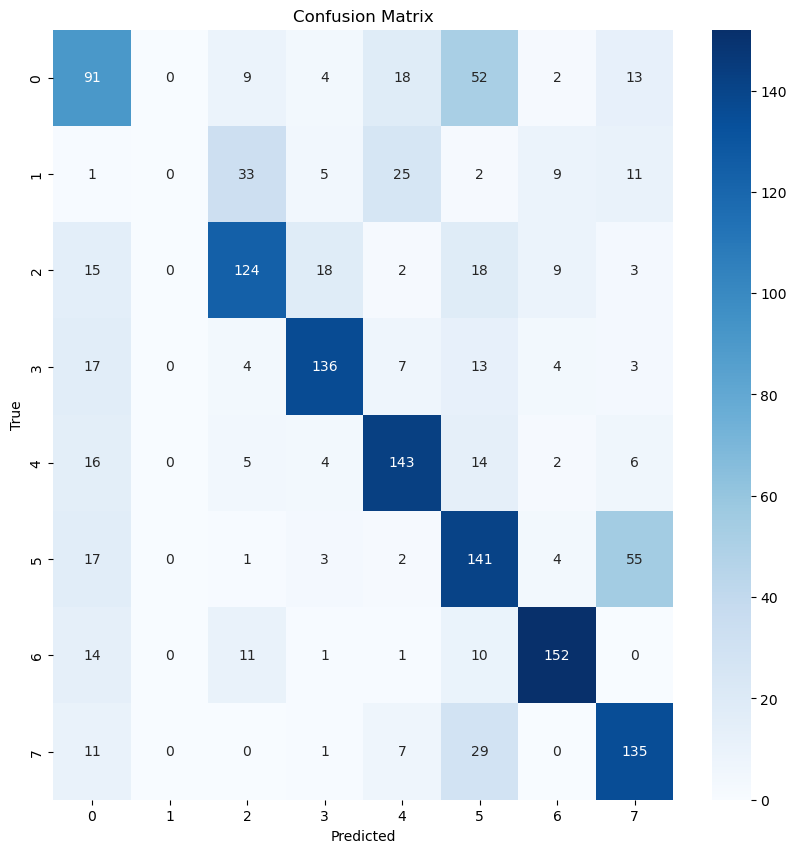

In [ ]:
# %%

plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(all_labels, all_preds),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# %%

# listen to the mixture, percussion and the separated percussion

# (batchsize, 31248) 9, 31248
mixture = mixture.cpu().numpy()
percussion = true_percussion.cpu().numpy()
separated_percussion = percussion_sep.cpu().detach().numpy()

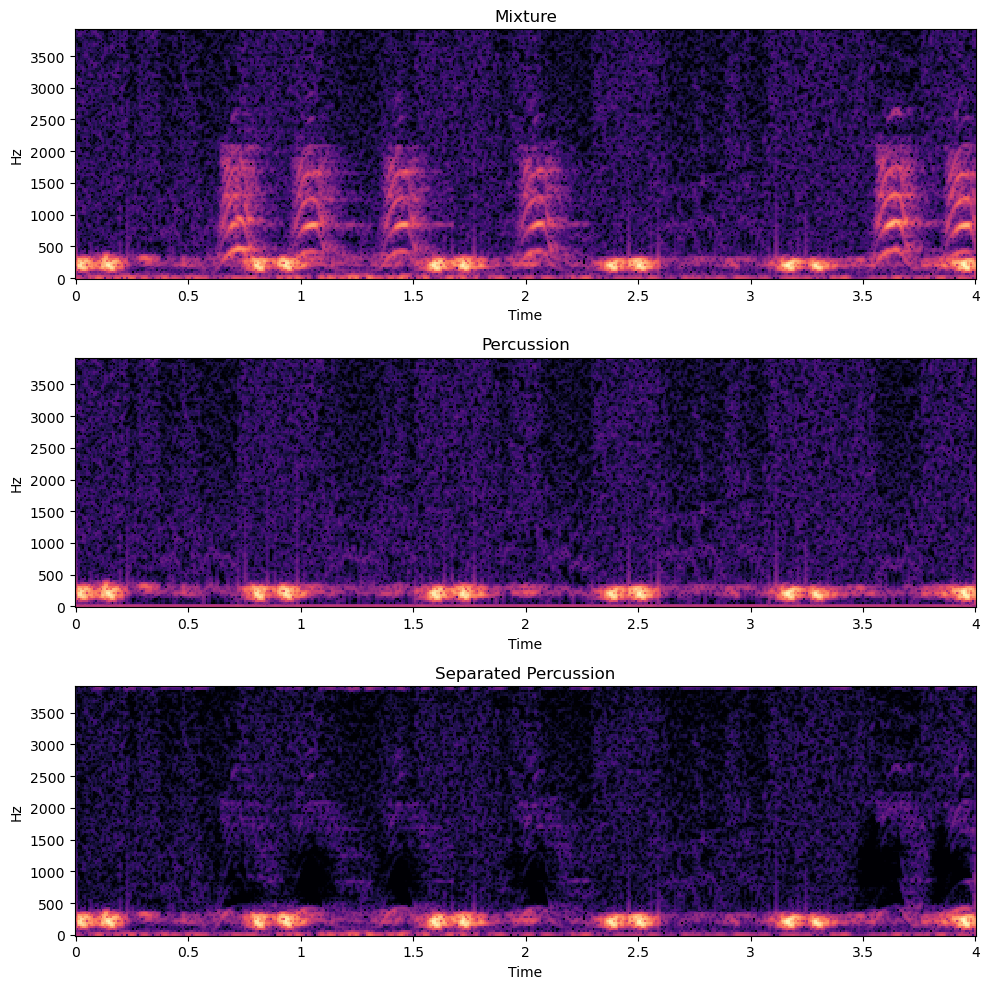

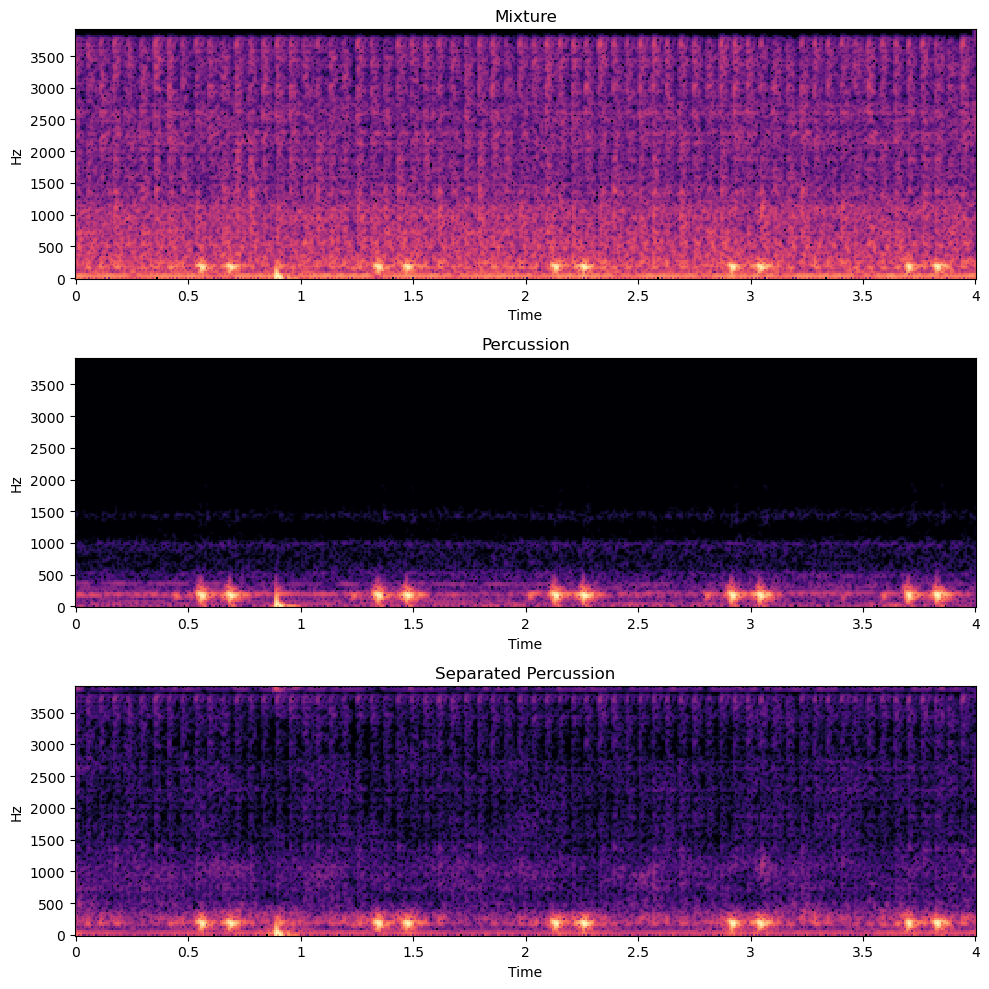

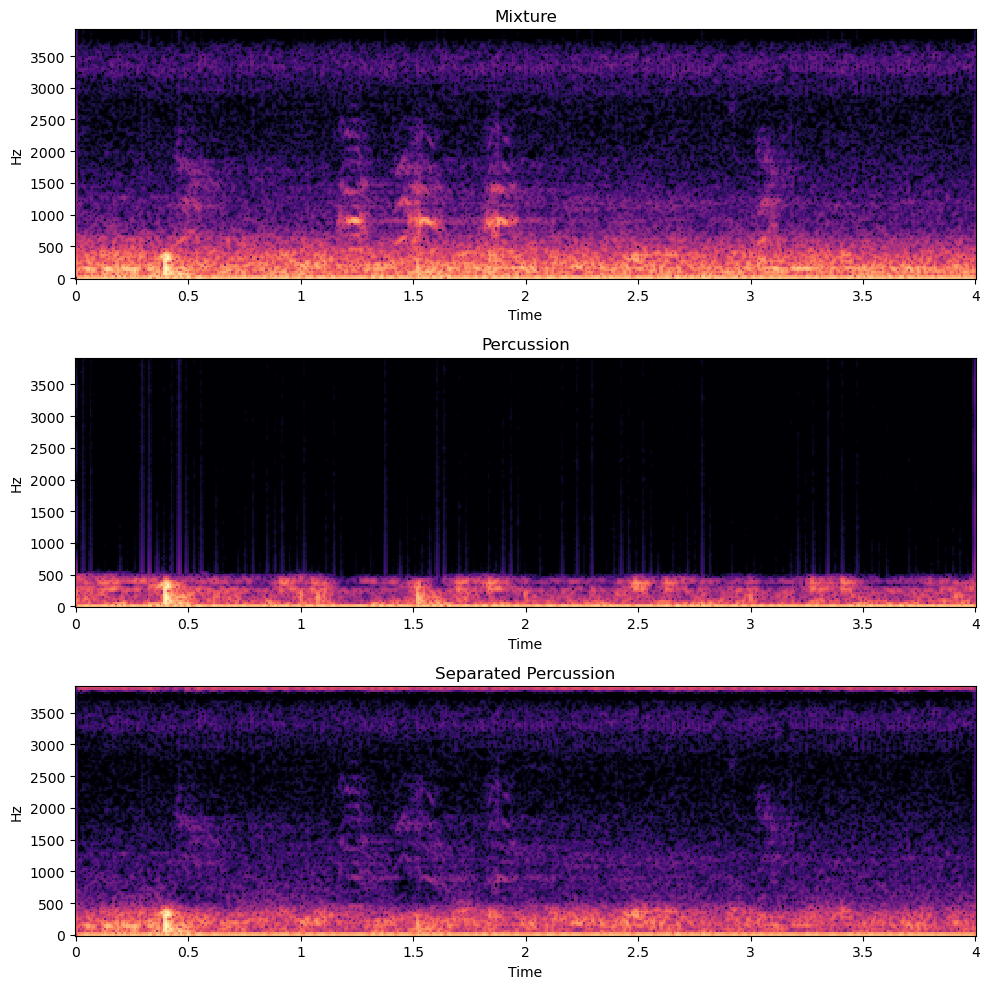

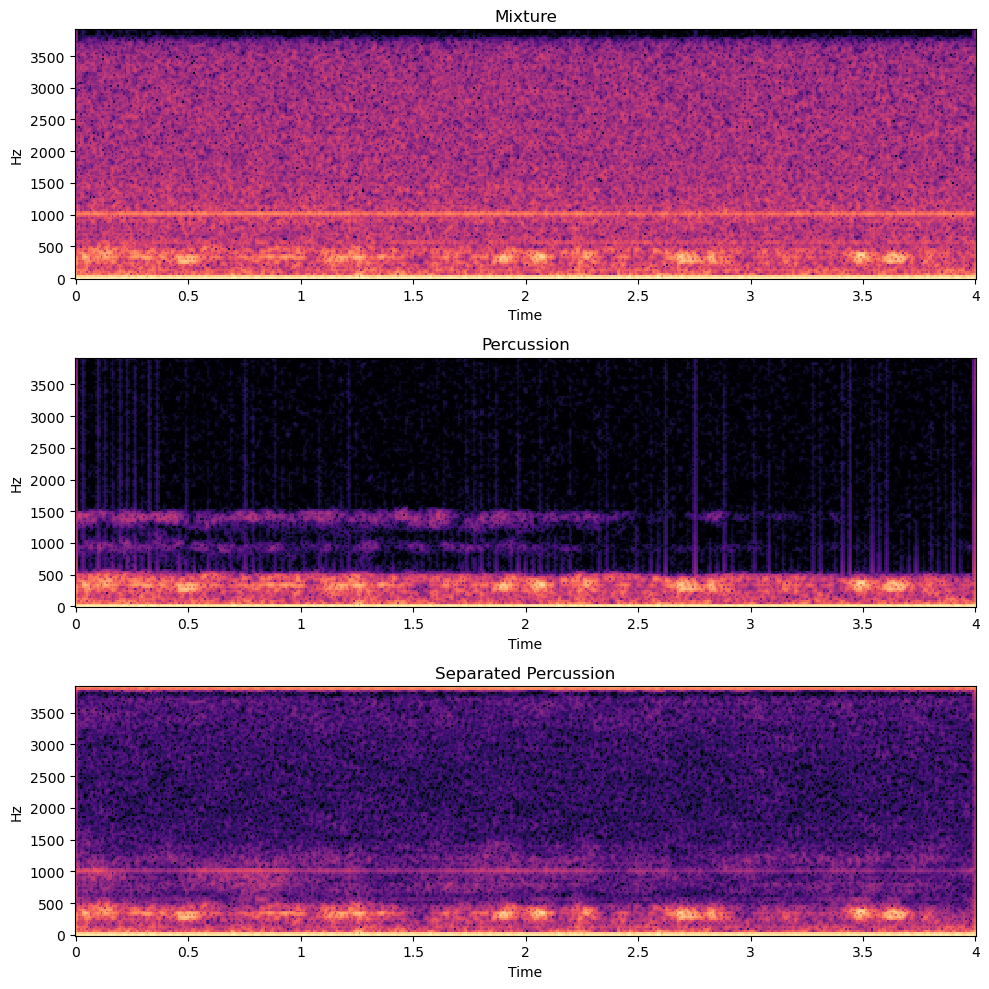

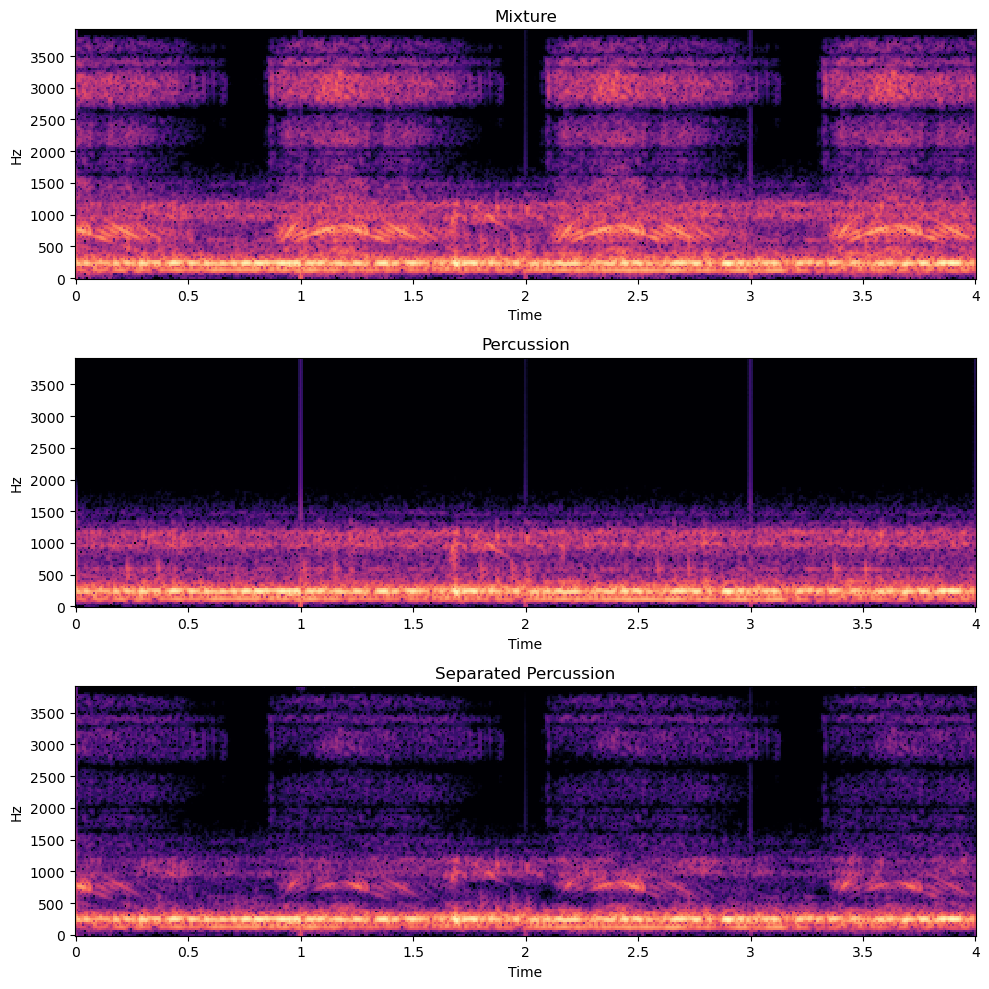

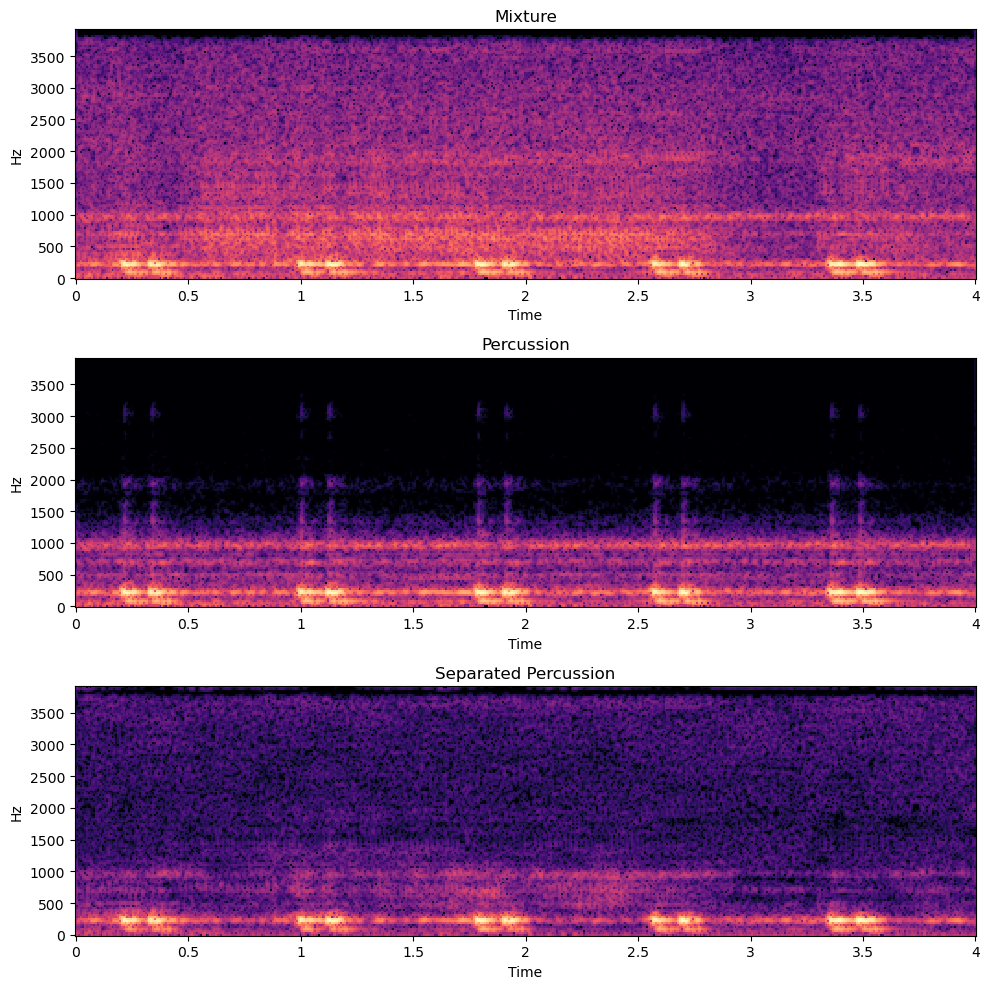

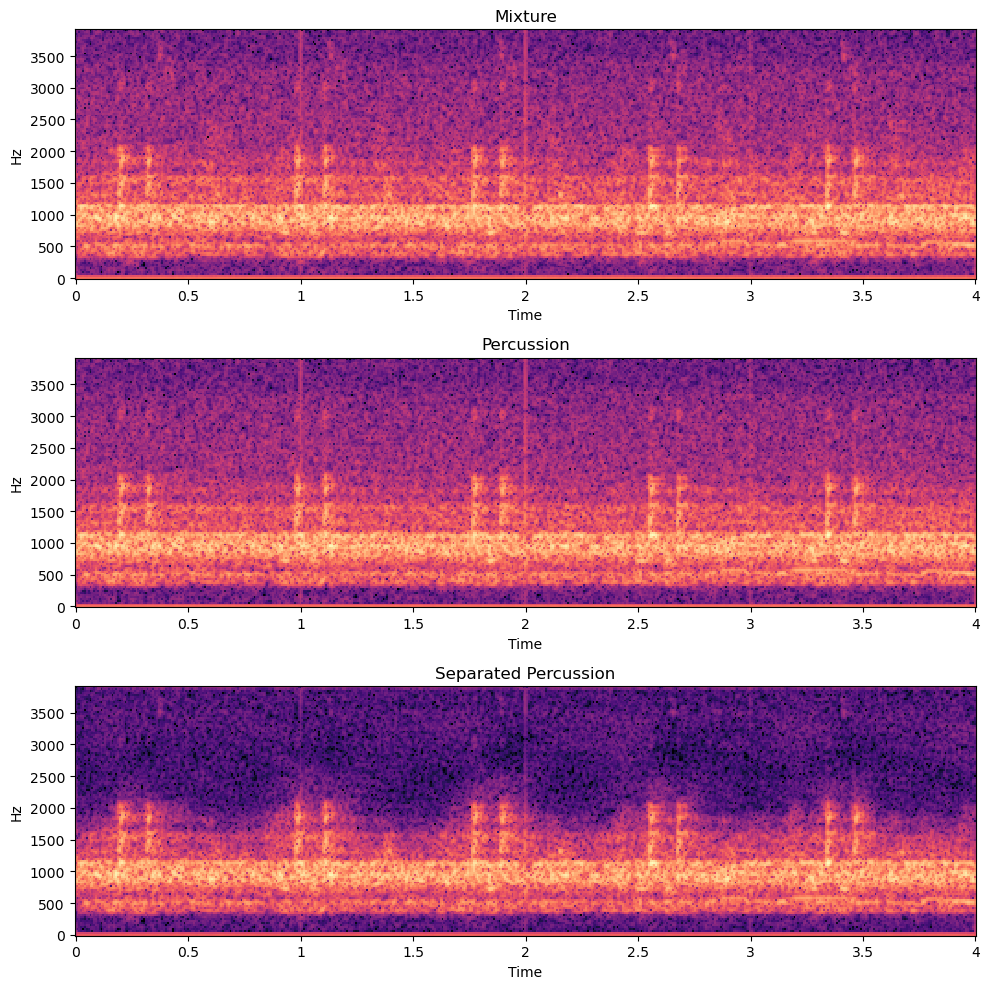

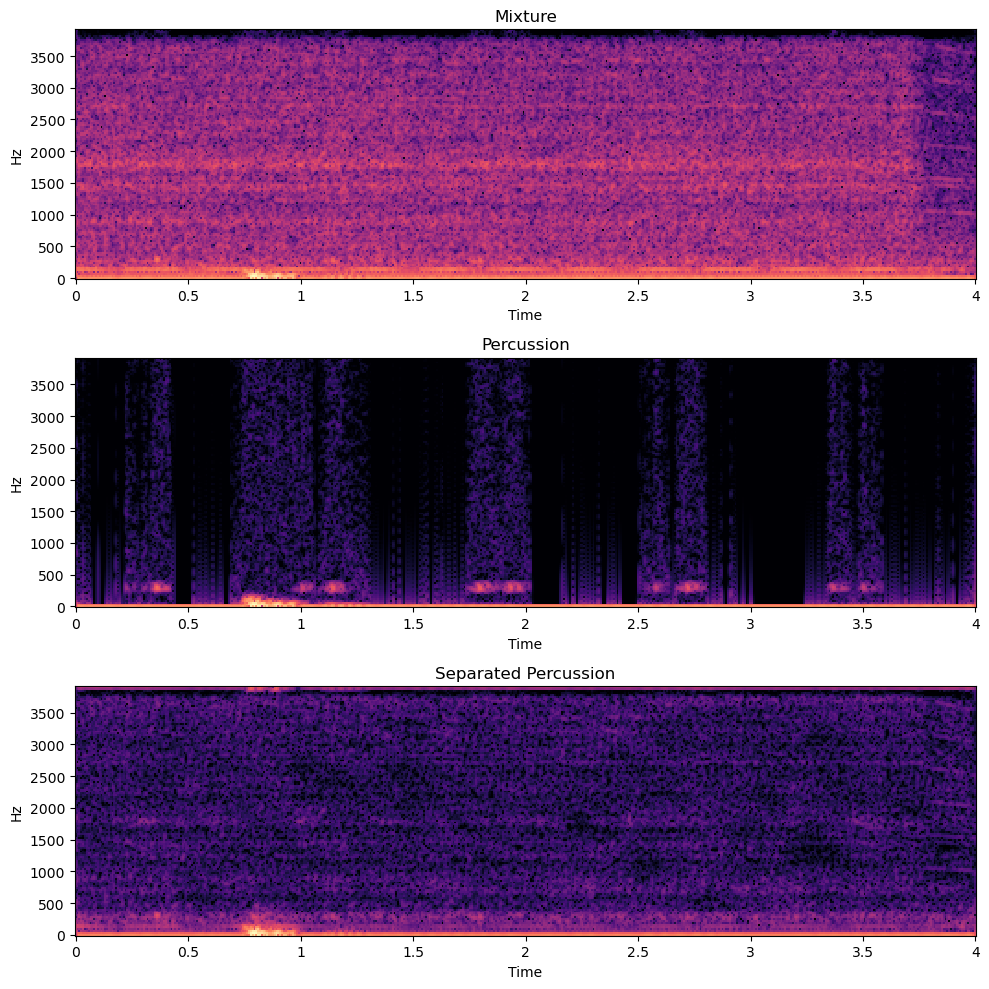

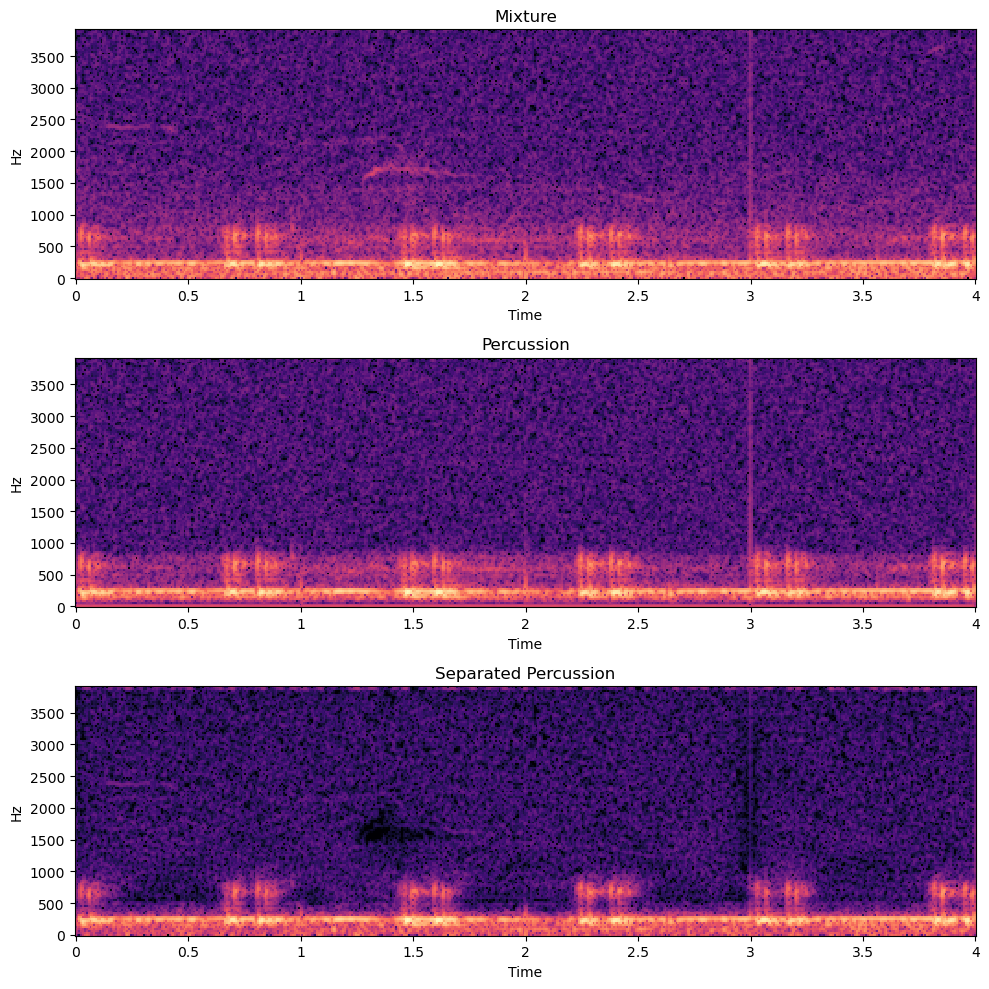

In [ ]:
# %%

# plot the spectrogram of the mixture, percussion and separated percussion

for i in range(9):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    # mixture
    mix_stft = librosa.stft(
        mixture[i], n_fft=256, hop_length=64, win_length=256)
    mix_mag, _ = librosa.magphase(mix_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        mix_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[0])
    ax[0].set_title('Mixture')
    # percussion
    perc_stft = librosa.stft(
        percussion[i], n_fft=256, hop_length=64, win_length=256)
    perc_mag, _ = librosa.magphase(perc_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        perc_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[1])
    ax[1].set_title('Percussion')
    # separated percussion
    sep_stft = librosa.stft(
        separated_percussion[i], n_fft=256, hop_length=64, win_length=256)
    sep_mag, _ = librosa.magphase(sep_stft)
    librosa.display.specshow(librosa.amplitude_to_db(
        sep_mag, ref=np.max), sr=7812, hop_length=64, x_axis='time', y_axis='linear', ax=ax[2])
    ax[2].set_title('Separated Percussion')
    plt.tight_layout()
    plt.show()